<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


### 0. Import packages

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import math
import re
import numpy as np


# Visualizaciones
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Para modelos NLP
# -----------------------------------------------------------------------
import spacy
from nltk.corpus import stopwords
import nltk
import contractions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler


from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity #  Cosine Similarity post Vectorizacion



# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)


# Gestionar emojis
# -----------------------------------------------------------------------
from emoji_extractor.extract import Extractor
import emoji

# Otros
# -----------------------------------------------------------------------
from collections import Counter

import sys 
sys.path.append("..")

from src import soporte_sistemas_recomendacion as sr

c:\Users\Miguel\.virtualenvs\Semana_11-bm8VIn16\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [10]:
nlp=spacy.load("en_core_web_sm")


nltk.download("stopwords")


extractor = Extractor()

def limpiar_columna(text):
    stop_words = set(stopwords.words("english"))
    text = str(text)
    text = contractions.fix(text)  # Convierte "don't" -> "do not"

    emojis = extractor.count_emoji(text, check_first=False) # extrae emojis
    emojis = emoji.demojize(" ".join(emojis)) # convierte emojis a texto
    emojis = re.sub(r'[^\w\s]', ' ', emojis) # reemplaza caracteres por espacios
    text = text + " " + emojis # une los emojis transformados a texto con el texto

    # Limpieza de texto
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^\w\s]', ' ', text)  # Eliminar puntuación
    text = re.sub(r'\d+', ' ', text)  # Eliminar números
    text = re.sub(r'\s+', ' ', text)  # Reemplazar múltiples espacios o saltos de línea por un espacio
    text = text.strip()  # Quitar espacios en blanco al inicio y al final
    doc = nlp(text)  # Tokenizar con spaCy


    # eliminamos las stop words
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.text.isalpha()]
    return tokens

def generar_bow(df, cleaned_text_column):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df[cleaned_text_column])
    similarity = cosine_similarity(X)
    similarity_matrix = pd.DataFrame(similarity, index=df[cleaned_text_column], columns=df[cleaned_text_column])
    return similarity_matrix

def generar_tfidf(df, cleaned_text_column):
    vectorizer_tfidf = TfidfVectorizer(max_features=10000)
    X_tfidf = vectorizer_tfidf.fit_transform(df[cleaned_text_column])
    similarity = cosine_similarity(X_tfidf)
    similarity_matrix = pd.DataFrame(similarity, index=df[cleaned_text_column], columns=df[cleaned_text_column])
    return similarity_matrix

def generar_recomendaciones(top_df_cliente, productos_df, score_column, similarity_matrix, w_score=1, w_similarity=4, n_recomendaciones = 5):

    total_similar_products = pd.DataFrame()
    for col in top_df_cliente["tags"].to_list():

        similarity_products = pd.DataFrame(similarity_matrix[col]).reset_index()
        similarity_products.columns = ["tags","similarity"]
        similarity_products["review_score"] = productos_df.loc[productos_df["tags"] == similarity_products["tags"],score_column]

        similarity_products["total_score"] = (similarity_products["review_score"] * w_score + similarity_products["similarity"] * w_similarity)/(2*(w_score + w_similarity))

        total_similar_products = pd.concat([total_similar_products,similarity_products],axis=0)

    total_similar_products = total_similar_products.sort_values(by="total_score", ascending=False).drop_duplicates(subset="tags")
    total_similar_products = total_similar_products[total_similar_products["similarity"]<0.9999999]
    
    return total_similar_products.nlargest(n_recomendaciones, columns=["total_score"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Import dataset

In [4]:
df = pd.read_csv("../datos/datos.csv", index_col=0)
df.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
65115,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
56720,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0
26571,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0
40292,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1
5884,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0


# 2. Inspección y limpieza

#### Duplicados

In [5]:
df.duplicated().sum()

np.int64(0)

#### Missing

In [6]:
df.isna().sum()

reviewId              0
reviewDate            0
mainDepartment        0
subDepartment         0
productName           0
reviewTitle           5
reviewStar            0
reviewText            1
inconsistentStatus    0
dtype: int64

Longitudes de review

In [7]:
df["reviewText"] = df["reviewText"].apply(str)
df["reviewText"].apply(len).describe()

count    10000.000000
mean       190.540800
std        242.453795
min          1.000000
25%         55.000000
50%        121.000000
75%        238.000000
max       5714.000000
Name: reviewText, dtype: float64

# 3. Preprocesado

Generar columna tag para aplicar los vectorizados y embeddings a partir de ella.

In [8]:
df["tags"] = df["subDepartment"] + " " + df["productName"]

Aplicar limpieza de contracciones, signos de puntuación, integracion de emojis, stopwords y tokenizacion.

In [14]:
import polars as pl
polars_df = pl.from_pandas(df)

ImportError: pyarrow is required for converting a pandas dataframe to Polars, unless each of its columns is a simple numpy-backed one (e.g. 'int64', 'bool', 'float32' - not 'Int64')

In [ ]:
df["tags"] = df["tags"].apply(limpiar_columna).str.join(" ")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'limpiar_columna' is not defined

Generar dataframe productos

In [ ]:
# generar a partir de agregaciones
productos = df.groupby(["mainDepartment","subDepartment", "productName"]).agg(n_reviews=("reviewId","count"),
                                                                  avg_review_score=("reviewStar","mean"),
                                                                  joint_reviews=("reviewText","sum")).reset_index()

# escalar columna de puntuación para luego usarla junto con la de similitudes
scaler = MinMaxScaler()
productos["avg_review_score_minmax"] = scaler.fit_transform(productos[["avg_review_score"]])

# enseñar nuevo df
print(f"El dataframe de productos tiene {productos.shape[0]} productos.")
productos.head()

El dataframe de productos tiene 99 productos.


,mainDepartment,subDepartment,productName,n_reviews,avg_review_score,joint_reviews,avg_review_score_minmax
0,Beauty and Personal Care,"Foot,Hand & Nail Care",AIMEILI Gel Nail Polish No Wipe Top and Base C...,155,3.077419,"It’s thick, but works good once you get used t...",0.590015
1,Beauty and Personal Care,"Foot,Hand & Nail Care",Hard As Hoof Nail Strengthening Cream with Coc...,132,3.083333,Noticed a difference after a few weeks. Five s...,0.593254
2,Beauty and Personal Care,"Foot,Hand & Nail Care",Harperton Nail Clippers Set - 2 Pack Stainless...,62,2.790323,I was crazy about these when I first used them...,0.432796
3,Beauty and Personal Care,Fragrance,"Cremo Blue Cedar & Cypress Cologne Spray, A Wo...",76,3.184211,Basically Spice Bomb. Literally super close to...,0.648496
4,Beauty and Personal Care,Fragrance,Nautica Voyage By Nautica For Men Eau De Toile...,106,2.971698,Scents goodDelivered to I incorrect residance...,0.532120


# 4. Sistemas de recomendacion

## 4.1 Bag of Words

#### Exploración de la solución

Juntar columnas de contenido de producto

In [ ]:
productos["tags"] = productos["subDepartment"] + " " + productos["productName"]
productos["tags"] = productos["tags"].apply(limpiar_columna).str.join(" ")
productos["tags"]

0     foot hand nail care aimeili gel nail polish wi...
1     foot hand nail care hard hoof nail strengthen ...
2     foot hand nail care harperton nail clipper set...
3     fragrance cremo blue cedar cypress cologne spr...
4     fragrance nautica voyage nautica man eau de to...
                            ...                        
94    sport fitness comfybrace posture corrector bac...
95    sport fitness fit simplify resistance loop exe...
96    sport fitness fitbit charge fitness activity t...
97    sport fitness saucony man multi pack mesh vent...
98            sport fitness wilson soft play volleyball
Name: tags, Length: 99, dtype: object

Generar vectores bag of words

In [ ]:
# Creamos el modelo Bag of Words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(productos["tags"])

# mostramos el  vocabulario
print("Vocabulario:", vectorizer.get_feature_names_out()[:20])

# mostramos los vectores
print("Representación BoW:")
print(X.toarray()[:20])

# calculamos sus distancias
similarity = cosine_similarity(X)
similarity[:20]

Vocabulario: ['absorb' 'absorbent' 'ac' 'accessory' 'acer' 'acid' 'acne' 'action'
 'activity' 'adapter' 'adidas' 'adilette' 'adjustable' 'adult' 'age'
 'ailun' 'aimeili' 'air' 'akaso' 'alarm']
Representación BoW:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


array([[1.        , 0.46947648, 0.47469288, ..., 0.        , 0.        ,
        0.        ],
       [0.46947648, 1.        , 0.51428571, ..., 0.        , 0.        ,
        0.        ],
       [0.47469288, 0.51428571, 1.        , ..., 0.        , 0.05547002,
        0.        ],
       ...,
       [0.03001501, 0.02348557, 0.0328798 , ..., 0.        , 0.        ,
        0.        ],
       [0.10540926, 0.05498574, 0.03849002, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.06622662, 0.        ,
        0.        ]])

In [ ]:
# definimos un producto de ejemplo para observar las similutudes
producto_usuario = list(productos["tags"])[2]

producto_indice = productos[productos["tags"] == producto_usuario].index.values[0]

# obtenemos productos similares
similar_product = list(enumerate(similarity[2]))
similar_product[:3]

[(0, np.float64(0.47469288317114394)),
 (1, np.float64(0.5142857142857142)),
 (2, np.float64(1.0000000000000002))]

Ordenamos los productos por similitud

In [ ]:
# ordenamos los productos
produtos_similares_ordenados = sorted(similar_product,key=lambda x:x[1],reverse=True)[1:21] # [1:21] si lo cambiamos a [0:21] la tenemos a ella misma 
produtos_similares_ordenados[:3]

[(1, np.float64(0.5142857142857142)),
 (0, np.float64(0.47469288317114394)),
 (49, np.float64(0.1))]

Plotear top 20 productos similares

El producto del usuario es:
'foot hand nail care harperton nail clipper set pack stainless steel professional fingernail toenail clipper thick nail'


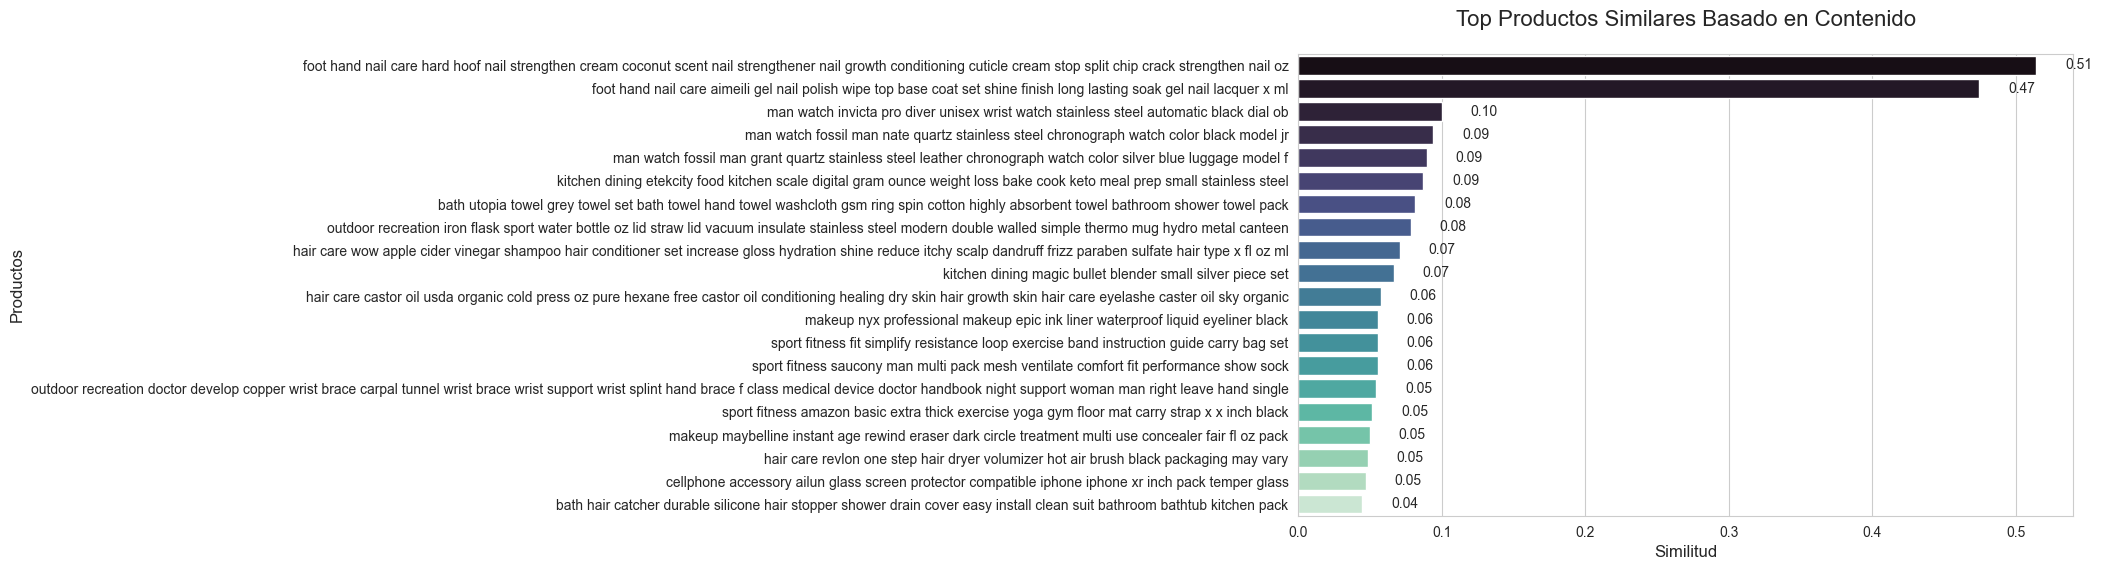

In [ ]:
# y ahora buscamos el producto
top_simiar_productos = {}
for i in produtos_similares_ordenados:

    top_simiar_productos[productos[productos.index == i[0]]["tags"].values[0]] = i[1]


print(f"El producto del usuario es:\n'{producto_usuario}'")
# visualizamos los resultados
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Crear gráfico de barras
sns.barplot(
    x=list(top_simiar_productos.values()), 
    y=list(top_simiar_productos.keys()), 
    hue=list(top_simiar_productos.keys()),
    palette="mako"
)

# Añadir etiquetas y título
plt.title("Top Productos Similares Basado en Contenido", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Productos", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top_simiar_productos.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

# plt.tight_layout()
plt.show()

### Implementación de la recomendacion

In [ ]:
similarity_matrix = generar_bow(productos, "tags")

Como no hay id de usuario, cogemos un sample de 50 productos y asumimos que corresponden al mismo usuario.

In [ ]:
productos_usuario = df.sample(50, random_state=42)
top5_usuario = productos_usuario.sort_values(by="reviewStar",ascending=False).head(5)
display(top5_usuario)

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus,tags
67314,R32AJP5CDVDN1N,"Reviewed in the United States on August 9, 2021",Sports and Outdoors,Outdoor Recreation,Coleman Sundome Tent,Nice tent,5.0,First time we brought it out to go camping it ...,0,outdoor recreation coleman sundome tent
32161,R1R6FT6FZE6AX3,"Reviewed in the United States on August 13, 2021",Electronics,CellPhones and Accessories,Ailun Glass Screen Protector Compatible for iP...,Easy to Install,5.0,Easy to install and reasonably priced. Have us...,0,cellphone accessory ailun glass screen protect...
59989,R397EMX1HQR9W1,"Reviewed in the United States on September 2, ...",Computers,Men's Shoes,Crocs Men's and Women's Classic Clog,perfet for every occasion,5.0,wearin' em right now. perfect foot wear.,0,man shoe croc man woman classic clog
47416,RI73UKLOL5FOI,"Reviewed in the United States on August 17, 2021",Home and Kitchen,Furniture,FURINNO Econ Multipurpose Home Office Computer...,So much room with a small desk!!,5.0,There is many cubbies that it fits all my need...,0,furniture furinno econ multipurpose home offic...
42331,RX1XL8QF4ZUZM,"Reviewed in the United States on July 10, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Value for the money,5.0,Value for the money,0,bath gorilla grip luxury chenille bathroom rug...


Sacar los 5 productos más parecidos según similaridad coseno

In [ ]:
generar_recomendaciones(top5_usuario, productos, "avg_review_score_minmax", similarity_matrix)

,tags,similarity,review_score,total_score
46,man shoe adidas man adilette shower slide,0.555556,0.617232,0.283945
42,man clothing gildan man crew shirt multipack,0.444444,0.679048,0.245683
45,man shoe new balance man v casual comfort cros...,0.502519,0.445187,0.245526
43,man clothing levi man regular fit jean,0.444444,0.597403,0.237518
87,outdoor recreation coleman cooler quad portabl...,0.447214,0.528736,0.231759


## 3.2 TF-IDF

#### Exploración de la solución

Generar vectores  TF-IDF

In [ ]:
# Creamos el objeto TF-IDF Vectorizer
vectorizer_tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = vectorizer_tfidf.fit_transform(productos["tags"])

# mostramos el  vocabulario
print("Vocabulario:", vectorizer.get_feature_names_out()[:20])

# mostramos los vectores
print("Representación TF-IDF:")
print(X_tfidf.toarray()[:20])

Vocabulario: ['absorb' 'absorbent' 'ac' 'accessory' 'acer' 'acid' 'acne' 'action'
 'activity' 'adapter' 'adidas' 'adilette' 'adjustable' 'adult' 'age'
 'ailun' 'aimeili' 'air' 'akaso' 'alarm']
Representación TF-IDF:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# calculamos sus distancias
similarity_tfidf = cosine_similarity(X_tfidf)
similarity_tfidf[:20]

array([[1.        , 0.41470663, 0.41459872, ..., 0.        , 0.        ,
        0.        ],
       [0.41470663, 1.        , 0.46479346, ..., 0.        , 0.        ,
        0.        ],
       [0.41459872, 0.46479346, 1.        , ..., 0.        , 0.03093516,
        0.        ],
       ...,
       [0.01717493, 0.01336292, 0.01924926, ..., 0.        , 0.        ,
        0.        ],
       [0.08529402, 0.03024354, 0.02242059, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02205862, 0.        ,
        0.        ]])

In [ ]:
# definimos un producto de ejemplo para observar las similutudes
producto_usuario = list(productos["tags"])[2]

producto_indice = productos[productos["tags"] == producto_usuario].index.values[0]

# obtenemos productos similares
similar_product_tfidf = list(enumerate(similarity_tfidf[2]))
similar_product_tfidf[:3]

[(0, np.float64(0.4145987220808558)),
 (1, np.float64(0.4647934630629966)),
 (2, np.float64(0.9999999999999998))]

Ordenamos los productos por similitud

In [ ]:
# ordenamos los productos
produtos_similares_ordenados_tfidf = sorted(similar_product_tfidf,key=lambda x:x[1],reverse=True)[1:21] # [1:21] si lo cambiamos a [0:21] la tenemos a ella misma 
produtos_similares_ordenados_tfidf[:3]

[(1, np.float64(0.4647934630629966)),
 (0, np.float64(0.4145987220808558)),
 (48, np.float64(0.07859602508369377))]

Plotear top 20 productos similares

El producto del usuario es:
'foot hand nail care harperton nail clipper set pack stainless steel professional fingernail toenail clipper thick nail'


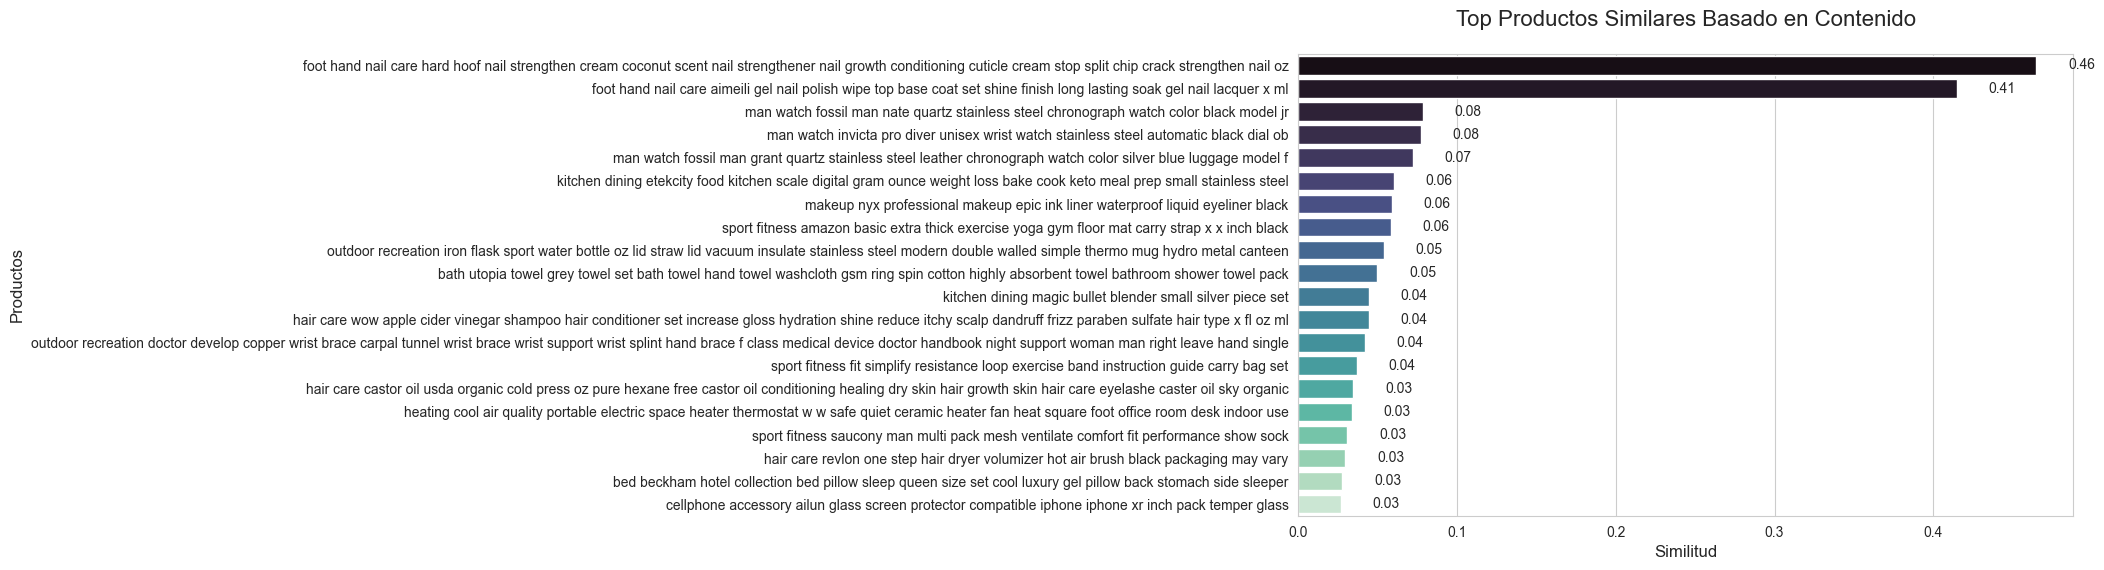

In [ ]:
# y ahora buscamos el producto
top_simiar_productos_tfidf = {}
for i in produtos_similares_ordenados_tfidf:

    top_simiar_productos_tfidf[productos[productos.index == i[0]]["tags"].values[0]] = i[1]


print(f"El producto del usuario es:\n'{producto_usuario}'")
# visualizamos los resultados
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Crear gráfico de barras
sns.barplot(
    x=list(top_simiar_productos_tfidf.values()), 
    y=list(top_simiar_productos_tfidf.keys()), 
    hue=list(top_simiar_productos_tfidf.keys()),
    palette="mako"
)

# Añadir etiquetas y título
plt.title("Top Productos Similares Basado en Contenido", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Productos", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top_simiar_productos_tfidf.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

# plt.tight_layout()
plt.show()

Parece que las recomendaciones parsa este producto son mas o menos las mismas. Lo que parece que cambian son las similitudes, que son ligeramente más bajas en la mayoría de productos, probablemente por la corrección de inverse frequency del TF-IDF. Se observa que por ejemplo, la 3a similitud del Bag of Words es ahora la 4a, por lo que en productos con descripciones similares es donde más impacta.

### Implementación de la recomendacion

In [ ]:
similarity_matrix_tfidf = generar_tfidf(productos, "tags")

Como no hay id de usuario, cogemos un sample de 50 productos y asumimos que corresponden al mismo usuario.

In [ ]:
productos_usuario = df.sample(50, random_state=42)
top5_usuario = productos_usuario.sort_values(by="reviewStar",ascending=False).head(5)
display(top5_usuario)

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus,tags
67314,R32AJP5CDVDN1N,"Reviewed in the United States on August 9, 2021",Sports and Outdoors,Outdoor Recreation,Coleman Sundome Tent,Nice tent,5.0,First time we brought it out to go camping it ...,0,outdoor recreation coleman sundome tent
32161,R1R6FT6FZE6AX3,"Reviewed in the United States on August 13, 2021",Electronics,CellPhones and Accessories,Ailun Glass Screen Protector Compatible for iP...,Easy to Install,5.0,Easy to install and reasonably priced. Have us...,0,cellphone accessory ailun glass screen protect...
59989,R397EMX1HQR9W1,"Reviewed in the United States on September 2, ...",Computers,Men's Shoes,Crocs Men's and Women's Classic Clog,perfet for every occasion,5.0,wearin' em right now. perfect foot wear.,0,man shoe croc man woman classic clog
47416,RI73UKLOL5FOI,"Reviewed in the United States on August 17, 2021",Home and Kitchen,Furniture,FURINNO Econ Multipurpose Home Office Computer...,So much room with a small desk!!,5.0,There is many cubbies that it fits all my need...,0,furniture furinno econ multipurpose home offic...
42331,RX1XL8QF4ZUZM,"Reviewed in the United States on July 10, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Value for the money,5.0,Value for the money,0,bath gorilla grip luxury chenille bathroom rug...


Sacar los 5 productos más parecidos según similaridad coseno

In [ ]:
generar_recomendaciones(top5_usuario, productos, "avg_review_score_minmax", similarity_matrix_tfidf)

,tags,similarity,review_score,total_score
46,man shoe adidas man adilette shower slide,0.555556,0.617232,0.283945
42,man clothing gildan man crew shirt multipack,0.444444,0.679048,0.245683
45,man shoe new balance man v casual comfort cros...,0.502519,0.445187,0.245526
43,man clothing levi man regular fit jean,0.444444,0.597403,0.237518
87,outdoor recreation coleman cooler quad portabl...,0.447214,0.528736,0.231759


## 3.2 TF-IDF



**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  